In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datos = pd.read_excel('C:/Users/Noel/Documents/Universidad/4º/2º Cuatri/Trabajo Fin de Grado/TFG_Datos.xlsx', usecols=['Fecha', 'P','G(i)','H_sun','T2m','WS10m','Int'])
#datos = pd.read_csv('C:/Users/Noel/Desktop/TFM/TFG_Datos.csv')
print(datos)

                  Fecha    P  G(i)  H_sun   T2m  WS10m  Int
0      2017-01-01 00:01  0.0   0.0    0.0  4.59   2.07  0.0
1      2017-01-01 01:01  0.0   0.0    0.0  4.57   2.07  0.0
2      2017-01-01 02:01  0.0   0.0    0.0  4.76   1.93  0.0
3      2017-01-01 03:01  0.0   0.0    0.0  5.34   1.79  0.0
4      2017-01-01 04:01  0.0   0.0    0.0  5.09   1.79  0.0
...                 ...  ...   ...    ...   ...    ...  ...
35059  2020-12-31 19:01  0.0   0.0    0.0  7.86   4.34  0.0
35060  2020-12-31 20:01  0.0   0.0    0.0  7.75   3.79  0.0
35061  2020-12-31 21:01  0.0   0.0    0.0  7.69   3.24  0.0
35062  2020-12-31 22:01  0.0   0.0    0.0  7.66   3.03  0.0
35063  2020-12-31 23:01  0.0   0.0    0.0  7.54   3.59  0.0

[35064 rows x 7 columns]


In [2]:
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d %H:%M')
datos = datos.set_index('Fecha')
datos = datos.sort_index()
datos.index = datos.index.to_period('T')
# Extraer la hora del índice
datos['hora'] = datos.index.hour
datos['mes'] = datos.index.month
datos.head()

C:\Users\Noel\AppData\Local\Temp\ipykernel_16236\2929780060.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datos.index = datos.index.to_period('T')


,P,G(i),H_sun,T2m,WS10m,Int,hora,mes
Fecha,,,,,,,,
2017-01-01 00:01,0.0,0.0,0.0,4.59,2.07,0.0,0,1
2017-01-01 01:01,0.0,0.0,0.0,4.57,2.07,0.0,1,1
2017-01-01 02:01,0.0,0.0,0.0,4.76,1.93,0.0,2,1
2017-01-01 03:01,0.0,0.0,0.0,5.34,1.79,0.0,3,1
2017-01-01 04:01,0.0,0.0,0.0,5.09,1.79,0.0,4,1


In [3]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
entrenamiento, validacion, prueba = train_val_test_split(datos)

print(f'Tamaño set de entrenamiento: {entrenamiento.shape}')
print(f'Tamaño set de validación: {validacion.shape}')
print(f'Tamaño set de prueba: {prueba.shape}')


Tamaño set de entrenamiento: (28051, 8)
Tamaño set de validación: (3506, 8)
Tamaño set de prueba: (3507, 8)


In [4]:
from sklearn.preprocessing import StandardScaler

def escalar_dataset(data_train,data_validation,data_test, col_ref):
    '''Escala el dataset utilizando StandardScaler.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo

    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

       # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_train.shape[1]

    # Generar listado con "scalers", 1 por cada covariable de entrada
    scalers = [StandardScaler() for _ in range(NFEATS)]

    # Escalamiento: se usarán todo los parámetros para escalar
    # Escalamiento de los valores de train,val y test
    datos_t = np.zeros(data_train.shape)
    datos_v = np.zeros(data_validation.shape)
    datos_ts = np.zeros(data_test.shape)

    for i, scaler in enumerate(scalers):
 # Escalar datos de entrenamiento
        datos_i = data_train.iloc[:, i].values.reshape(-1, 1)
        datos_t[:, i] = scaler.fit_transform(datos_i).flatten()

        # Escalar datos de validación
        datos_j = data_validation.iloc[:, i].values.reshape(-1, 1)
        datos_v[:, i] = scaler.transform(datos_j).flatten()

        # Escalar datos de prueba
        datos_k = data_test.iloc[:, i].values.reshape(-1, 1)
        datos_ts[:, i] = scaler.transform(datos_k).flatten()

    return datos_t,datos_v,datos_ts, scalers[data_train.columns.get_loc(col_ref)]

# Escalar el dataset con la función anterior
tr, vl, ts, scaler = escalar_dataset(entrenamiento, validacion, prueba, col_ref='P')

# Convertir los resultados a DataFrame
tr = pd.DataFrame(tr, columns=list(datos.columns.values))
vl = pd.DataFrame(vl, columns=list(datos.columns.values))
ts = pd.DataFrame(ts, columns=list(datos.columns.values))


In [5]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    fils, cols = array.shape # Se realiza de esta forma porque se tienen vairas series (multivariado)

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols])

        # Salida (el índice 0 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,0].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 2    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (28025, 24, 8), y_tr: (28025, 2, 1)
Set de validación - x_vl: (3480, 24, 8), y_vl: (3480, 2, 1)
Set de prueba - x_ts: (3481, 24, 8), y_ts: (3481, 2, 1)


In [6]:
# Define the Attention layer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, Layer,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()


class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [39]:
def create_model(input_shape,output_length):
    inputs = Input(shape=input_shape)
    Do=0.3
    num_layers_Conv=3
    num_layers_LSTM=5
    units=[200,100,50,40,20]
    filtros=[128,64,32]
    x = Conv1D(filters=filtros[0], kernel_size=3, padding='same', activation='relu')(inputs)
    x = Dropout(Do)(x)
    # Añadir capas intermedias (si las hay)
    for i,filtro in zip(range(1, num_layers_Conv), filtros[1:]):
        x = Conv1D(filters=filtro, kernel_size=3, padding='same', activation='relu')(x)
        x = Dropout(Do)(x)
    x = MaxPooling1D(pool_size=2)(x)
    

    # Añadir capas intermedias (si las hay)
    for i,neurons in zip(range(0, num_layers_LSTM), units):
        x = LSTM(neurons, return_sequences=True)(x)
        x = Dropout(Do)(x)

    attention = Attention()(x)
    
    outputs = Dense(output_length)(attention)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

modelo = create_model((x_tr.shape[1], x_tr.shape[2]), y_tr.shape[1])
modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 128)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 12, 200)        │       186,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 12, 100)        │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 12, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 12, 40)         │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 20)         │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 20)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,530 (1.49 MB)

 Trainable params: 390,530 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
early_stop = EarlyStopping(
    monitor='val_loss',      # Métrica a monitorear
    patience=10,             # Número de épocas sin mejora para detener
    restore_best_weights=True  # Restaura los pesos de la mejor época
)

historia = modelo.fit(
    x = x_tr,
    y = y_tr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl, y_vl),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
219/219 - 21s - 95ms/step - loss: 0.3454 - mean_absolute_error: 0.3630 - root_mean_squared_error: 0.5877 - val_loss: 0.3046 - val_mean_absolute_error: 0.3192 - val_root_mean_squared_error: 0.5519
Epoch 2/100
219/219 - 17s - 77ms/step - loss: 0.2529 - mean_absolute_error: 0.2930 - root_mean_squared_error: 0.5029 - val_loss: 0.1555 - val_mean_absolute_error: 0.2401 - val_root_mean_squared_error: 0.3944
Epoch 3/100
219/219 - 17s - 77ms/step - loss: 0.1557 - mean_absolute_error: 0.2244 - root_mean_squared_error: 0.3946 - val_loss: 0.1575 - val_mean_absolute_error: 0.2222 - val_root_mean_squared_error: 0.3968
Epoch 4/100
219/219 - 16s - 73ms/step - loss: 0.1452 - mean_absolute_error: 0.2106 - root_mean_squared_error: 0.3810 - val_loss: 0.1581 - val_mean_absolute_error: 0.2285 - val_root_mean_squared_error: 0.3976
Epoch 5/100
219/219 - 18s - 80ms/step - loss: 0.1401 - mean_absolute_error: 0.2032 - root_mean_squared_error: 0.3742 - val_loss: 0.1734 - val_mean_absolute_error: 0.237

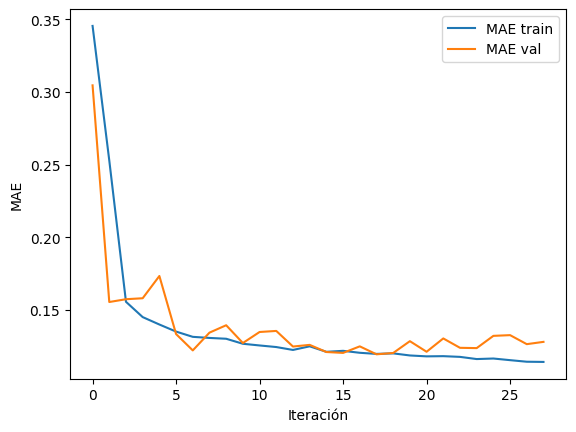

In [ ]:
plt.plot(historia.history['loss'],label='MSE train')
plt.plot(historia.history['val_loss'],label='MSE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

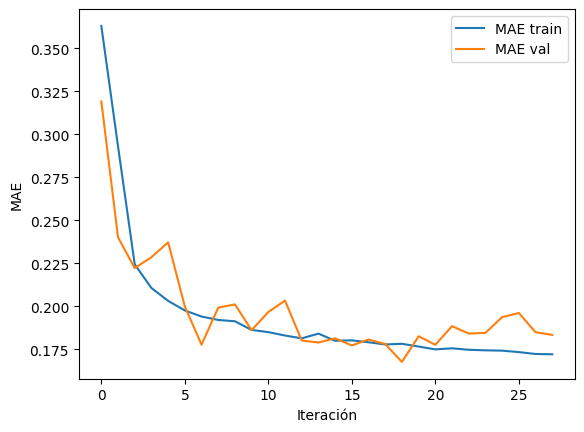

In [16]:
plt.plot(historia.history['mean_absolute_error'],label='MAE train')
plt.plot(historia.history['val_mean_absolute_error'],label='MAE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

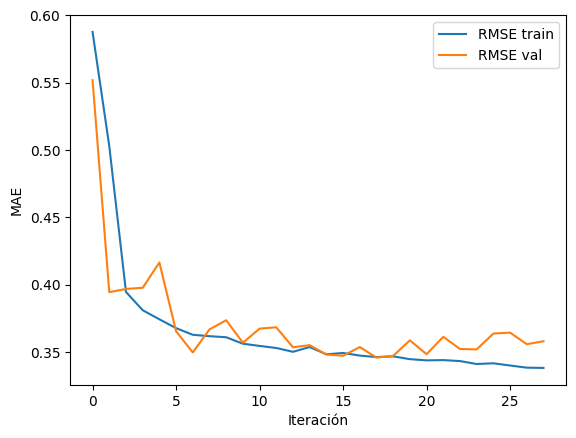

In [15]:
plt.plot(historia.history['root_mean_squared_error'],label='RMSE train')
plt.plot(historia.history['val_root_mean_squared_error'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('MAE')
plt.legend();

In [27]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred

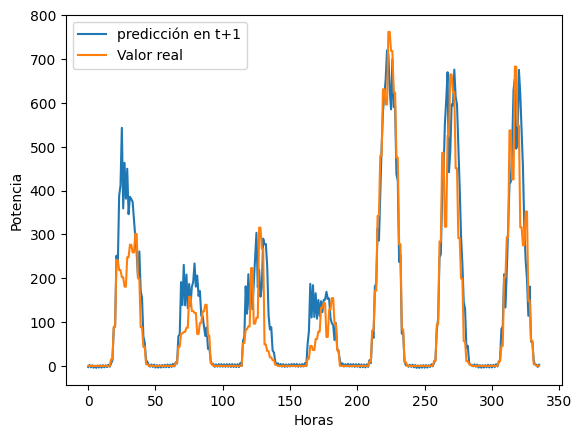

In [33]:
hpredic=168
a=x_ts[:hpredic]
pred=predecir(a, modelo, scaler)
t1 = np.array([])  # Inicializar t1 como un array vacío
t2 = np.array([])  # Inicializar t2 como un array vacío
real = np.array([])  # Inicializar t2 como un array vacío
for i in range(hpredic):
  if i%2 == 0:
    t1= np.concatenate((t1, [pred[i]]))
  else:
    t2=np.concatenate((t2, [pred[i]]))

y_real = y_ts[:168]
t1=np.concatenate((t1, [0]))
t2=np.concatenate(([0], t2))
plt.plot(pred,label='predicción en t+1')
plt.plot(scaler.inverse_transform(y_real[:hpredic].reshape(-1, 1)).reshape(-1),label='Valor real')
plt.xlabel('Horas')
plt.ylabel('Potencia')
plt.legend();

<function matplotlib.pyplot.show(close=None, block=None)>

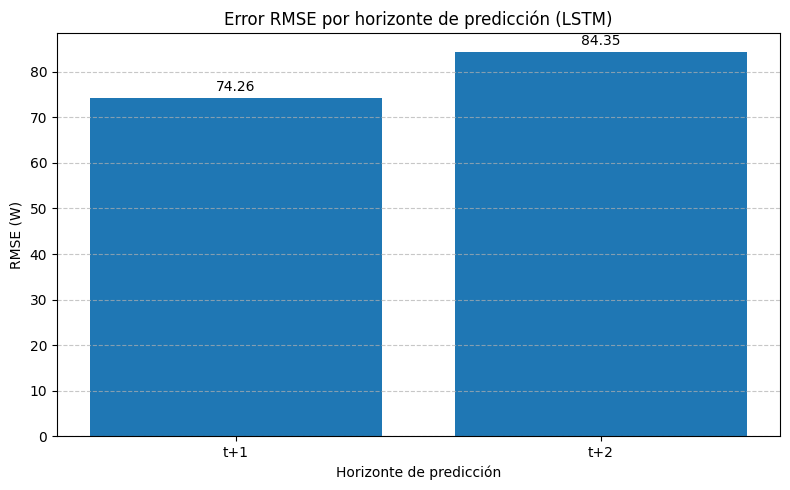

In [28]:
from sklearn.metrics import mean_squared_error
rmse_list = []
output_length=2
y_real=scaler.inverse_transform(y_ts.reshape(-1, output_length))
pred=predecir(x_ts, modelo, scaler)
for i in range(output_length):
    rmse = np.sqrt(mean_squared_error(y_real[:, i], pred[:, i]))
    rmse_list.append(rmse)
horizontes = [f't+{i+1}' for i in range(output_length)]
# Graficar barras
plt.figure(figsize=(8, 5))
plt.bar(horizontes, rmse_list)
plt.xlabel('Horizonte de predicción')
plt.ylabel('RMSE (W)')
plt.title('Error RMSE por horizonte de predicción (LSTM)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Mostrar los valores numéricos arriba de las barras
for i, val in enumerate(rmse_list):
    plt.text(i, val + 0.01 * max(rmse_list), f'{val:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show

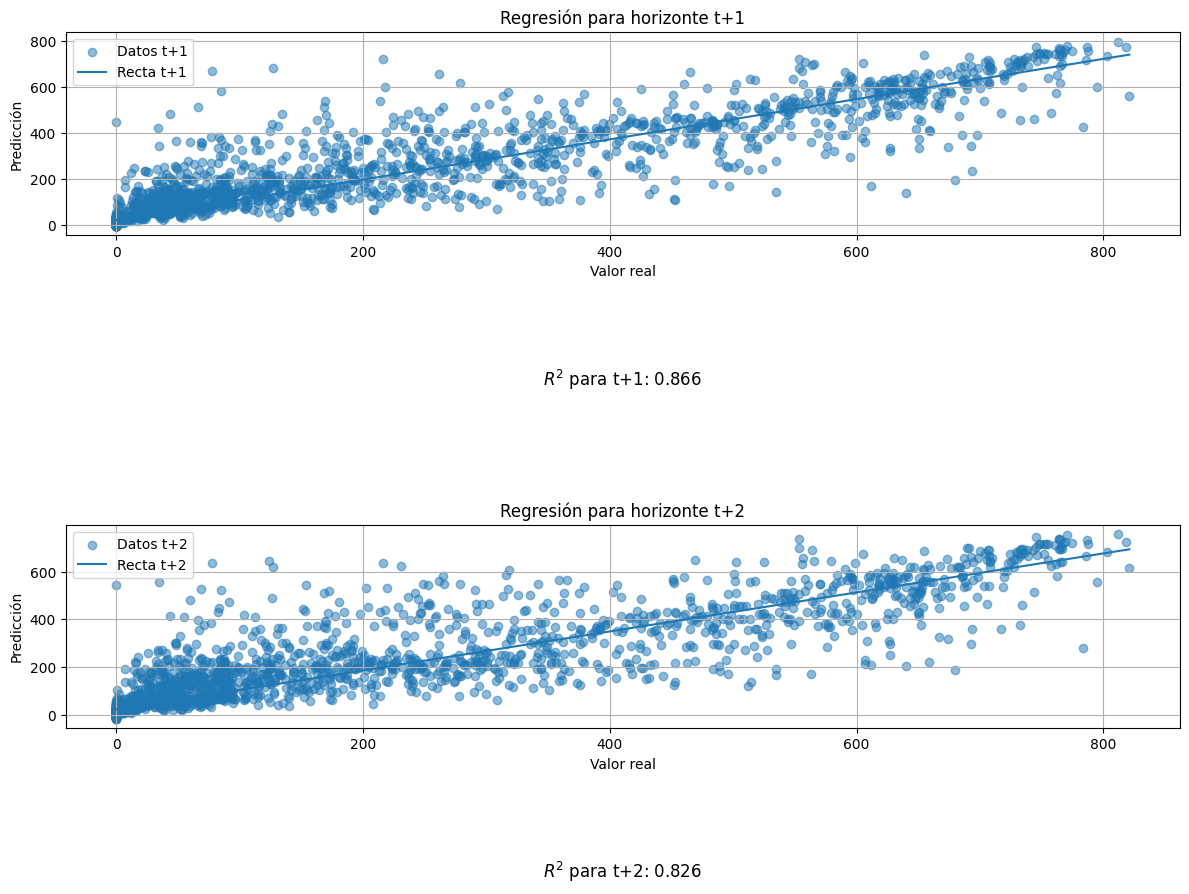

In [38]:
from sklearn.metrics import r2_score

fig, axs = plt.subplots(output_length,1,figsize=(12,10))

for i,ax in enumerate(axs):
    x = y_real[:, i]
    y = pred[:, i]

    # Ajuste lineal: coeficientes [pendiente, intercepto]
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)

    # Dibujar puntos reales vs predichos
    ax.scatter(x, y, label=f'Datos t+{i+1}', alpha=0.5)

    # Dibujar recta de regresión
    x_line = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(x_line, poly1d_fn(x_line), label=f'Recta t+{i+1}')

    # R2 para info en leyenda
    r2 = r2_score(x, y)
        # Texto debajo del gráfico
    ax.text(0.5, -0.65, f"$R^2$ para t+{i+1}: {r2:.3f}",
            transform=ax.transAxes,
            ha='center', va='top', fontsize=12)

    ax.set_xlabel("Valor real")
    ax.set_ylabel("Predicción")
    ax.legend()
    ax.set_title(f'Regresión para horizonte t+{i+1}')
    ax.grid(True)
plt.tight_layout()
plt.show()